In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.utils import save_image

import torchvision
from torchvision.utils import make_grid
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import random
import numpy as np

In [2]:
seed = 2
#GPU
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [3]:
#path of our dataset
F = 'bridal_dataset' #our dataset
T = 'bridal_dataset_test' #dataset for test
R = 'bridal_out'

In [4]:
#importing data
Tdata = 'bridal_dataset'
trans = transforms.Compose([ transforms.Resize((32, 32)), transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5),  transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]) ])
Train = datasets.ImageFolder(Tdata, transform = trans)
TrainLD = DataLoader(train_set,batch_size = 32, shuffle= True, num_workers = 0)

In [5]:
def gen(size):
    X = torch.rand(size, 3, 128 ,128).to(device, dtype=torch.float)
    return X

In [26]:
def acc(output, target, reverse=False):
    pred = torch.reshape(output >= 0.5,(1,len(output)))
    truth = torch.reshape(target < 0.5,(1,len(target)))
    accuracy = ((pred == truth).sum()).item() / len(target)* 100
    return accuracy

In [8]:
#discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
            
        )
        self.fc = nn.Sequential(
            nn.Linear(8*8*1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 8*8*1024)
        x = self.fc(x)
        return x

In [27]:
#generator architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 8*8*1024),
            nn.LeakyReLU(0.1))
        
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=0), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        
            nn.Conv2d(64, 3, 5, stride=1, padding=1),
            nn.Tanh() )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 1024, 8, 8)
        x = self.cnn(x)
        return x

In [29]:
def app(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

In [31]:
discriminator = Discriminator().to(device)
discriminator.apply(app)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True

In [30]:
generator = Generator().to(device)
generator.apply(app)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [18]:
optimizer_g = optim.SGD(generator.parameters(), lr=0.00015, momentum=0.9)
criterion = lambda output, target: F.binary_cross_entropy(input=output,target=target)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.00015, betas = (0.5,0.999))


Epoch : 0 



C:\Users\BasuUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  """Entry point for launching an IPython kernel.


***************************************
batch number= 0
discriminator Loss= 2.7989 | generator Loss= 27.6310 
Loss=: 0.6634 | fake Loss= 2.1356
***************************************
batch number= 5
discriminator Loss= 1.7487 | generator Loss= 27.6310 
Loss=: 0.4517 | fake Loss= 1.2969
***************************************
batch number= 10
discriminator Loss= 2.2478 | generator Loss= 27.6310 
Loss=: 0.4889 | fake Loss= 1.7589
***************************************
batch number= 15
discriminator Loss= 1.1967 | generator Loss= 27.6310 
Loss=: 0.6863 | fake Loss= 0.5105
***************************************
batch number= 20
discriminator Loss= 0.8747 | generator Loss= 27.6310 
Loss=: 0.4308 | fake Loss= 0.4439
***************************************
batch number= 25
discriminator Loss= 2.0889 | generator Loss= 27.6310 
Loss=: 0.5278 | fake Loss= 1.5611
***************************************
batch number= 30
discriminator Loss= 3.7629 | generator Loss= 27.6310 
Loss=: 1.0838 | fake 

C:\Users\BasuUser\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])) is deprecated. Please ensure they have the same size.
  """Entry point for launching an IPython kernel.



Discriminator Loss= 3.721449851989746
Generator Loss= 27.63102149963379
Minimum Loss: 27.63102149963379


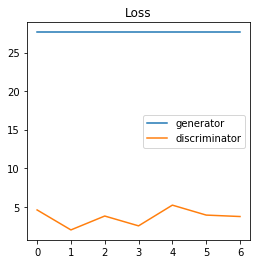


Epoch : 1 

***************************************
batch number= 0
discriminator Loss= 1.0080 | generator Loss= 27.6310 
Loss=: 0.4330 | fake Loss= 0.5750
***************************************
batch number= 5
discriminator Loss= 1.7842 | generator Loss= 27.6310 
Loss=: 0.5676 | fake Loss= 1.2166
***************************************
batch number= 10
discriminator Loss= 2.8744 | generator Loss= 27.6310 
Loss=: 0.8637 | fake Loss= 2.0107
***************************************
batch number= 15
discriminator Loss= 2.2719 | generator Loss= 27.6310 
Loss=: 0.7975 | fake Loss= 1.4744
***************************************
batch number= 20
discriminator Loss= 3.2522 | generator Loss= 27.6310 
Loss=: 0.6610 | fake Loss= 2.5912
***************************************
batch number= 25
discriminator Loss= 2.8451 | generator Loss= 27.6310 
Loss=: 0.9951 | fake Loss= 1.8500
***************************************
batch number= 30
discriminator Loss= 4.1910 | generator Loss= 27.6310 
Loss=: 1

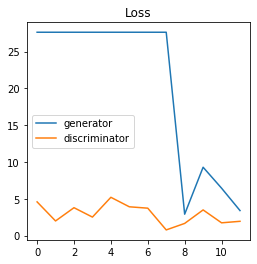


Epoch : 6 

***************************************
batch number= 0
discriminator Loss= 1.1009 | generator Loss= 5.2770 
Loss=: 0.7467 | fake Loss= 0.3543
***************************************
batch number= 5
discriminator Loss= 1.2793 | generator Loss= 1.0651 
Loss=: 1.1264 | fake Loss= 0.1530
***************************************
batch number= 10
discriminator Loss= 2.4527 | generator Loss= 1.3589 
Loss=: 2.1218 | fake Loss= 0.3309
***************************************
batch number= 15
discriminator Loss= 1.3705 | generator Loss= 5.2062 
Loss=: 0.7717 | fake Loss= 0.5988
***************************************
batch number= 20
discriminator Loss= 1.2081 | generator Loss= 1.6434 
Loss=: 0.8134 | fake Loss= 0.3947
***************************************
batch number= 25
discriminator Loss= 2.1789 | generator Loss= 2.9884 
Loss=: 2.1184 | fake Loss= 0.0605
***************************************
batch number= 30
discriminator Loss= 0.8707 | generator Loss= 4.2941 
Loss=: 0.6282 |

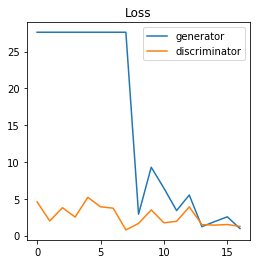


Epoch : 11 

***************************************
batch number= 0
discriminator Loss= 2.3080 | generator Loss= 1.6000 
Loss=: 0.6759 | fake Loss= 1.6321
***************************************
batch number= 5
discriminator Loss= 1.3215 | generator Loss= 4.0406 
Loss=: 0.8467 | fake Loss= 0.4748
***************************************
batch number= 10
discriminator Loss= 2.0724 | generator Loss= 1.3708 
Loss=: 1.3524 | fake Loss= 0.7200
***************************************
batch number= 15
discriminator Loss= 2.8427 | generator Loss= 1.9526 
Loss=: 2.5296 | fake Loss= 0.3131
***************************************
batch number= 20
discriminator Loss= 2.0446 | generator Loss= 1.2915 
Loss=: 1.0976 | fake Loss= 0.9470
***************************************
batch number= 25
discriminator Loss= 2.4794 | generator Loss= 1.7454 
Loss=: 1.4911 | fake Loss= 0.9882
***************************************
batch number= 30
discriminator Loss= 1.2891 | generator Loss= 1.1316 
Loss=: 1.1106 

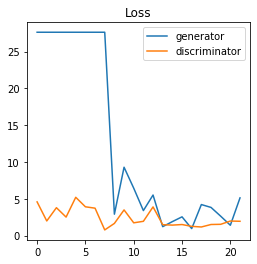


Epoch : 16 

***************************************
batch number= 0
discriminator Loss= 2.8341 | generator Loss= 1.0031 
Loss=: 2.4064 | fake Loss= 0.4277
***************************************
batch number= 5
discriminator Loss= 1.3565 | generator Loss= 3.3958 
Loss=: 0.7923 | fake Loss= 0.5642
***************************************
batch number= 10
discriminator Loss= 2.4053 | generator Loss= 3.4083 
Loss=: 0.9298 | fake Loss= 1.4755
***************************************
batch number= 15
discriminator Loss= 1.9458 | generator Loss= 2.3273 
Loss=: 0.8496 | fake Loss= 1.0963
***************************************
batch number= 20
discriminator Loss= 1.1140 | generator Loss= 3.8604 
Loss=: 0.5445 | fake Loss= 0.5694
***************************************
batch number= 25
discriminator Loss= 1.6956 | generator Loss= 1.9466 
Loss=: 0.9281 | fake Loss= 0.7675
***************************************
batch number= 30
discriminator Loss= 1.6449 | generator Loss= 3.0694 
Loss=: 1.6221 

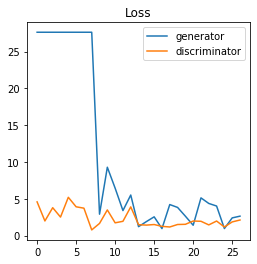


Epoch : 21 

***************************************
batch number= 0
discriminator Loss= 2.2696 | generator Loss= 1.4960 
Loss=: 1.6596 | fake Loss= 0.6100
***************************************
batch number= 5
discriminator Loss= 1.4213 | generator Loss= 3.3040 
Loss=: 0.5557 | fake Loss= 0.8656
***************************************
batch number= 10
discriminator Loss= 1.8525 | generator Loss= 1.8610 
Loss=: 0.8492 | fake Loss= 1.0032
***************************************
batch number= 15
discriminator Loss= 1.5071 | generator Loss= 0.9815 
Loss=: 1.2146 | fake Loss= 0.2925
***************************************
batch number= 20
discriminator Loss= 1.3124 | generator Loss= 1.2317 
Loss=: 0.9775 | fake Loss= 0.3349
***************************************
batch number= 25
discriminator Loss= 1.5495 | generator Loss= 2.2224 
Loss=: 0.9700 | fake Loss= 0.5795
***************************************
batch number= 30
discriminator Loss= 1.9863 | generator Loss= 1.4021 
Loss=: 1.5941 

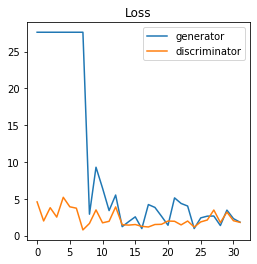


Epoch : 26 

***************************************
batch number= 0
discriminator Loss= 2.6771 | generator Loss= 1.2886 
Loss=: 1.6948 | fake Loss= 0.9823
***************************************
batch number= 5
discriminator Loss= 0.9702 | generator Loss= 2.8867 
Loss=: 0.7454 | fake Loss= 0.2248
***************************************
batch number= 10
discriminator Loss= 1.5038 | generator Loss= 1.9421 
Loss=: 0.5295 | fake Loss= 0.9743
***************************************
batch number= 15
discriminator Loss= 2.0117 | generator Loss= 2.1382 
Loss=: 1.6647 | fake Loss= 0.3470
***************************************
batch number= 20
discriminator Loss= 1.9827 | generator Loss= 3.8560 
Loss=: 0.7290 | fake Loss= 1.2536
***************************************
batch number= 25
discriminator Loss= 1.2473 | generator Loss= 3.3992 
Loss=: 0.9245 | fake Loss= 0.3227
***************************************
batch number= 30
discriminator Loss= 1.4714 | generator Loss= 1.1190 
Loss=: 1.1395 

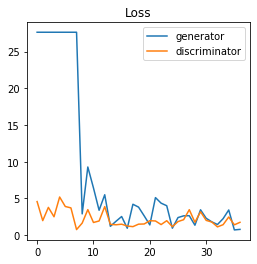


Epoch : 31 

***************************************
batch number= 0
discriminator Loss= 1.7013 | generator Loss= 2.6414 
Loss=: 0.7902 | fake Loss= 0.9111
***************************************
batch number= 5
discriminator Loss= 1.5922 | generator Loss= 1.5859 
Loss=: 0.9546 | fake Loss= 0.6376
***************************************
batch number= 10
discriminator Loss= 2.5106 | generator Loss= 3.2439 
Loss=: 1.0250 | fake Loss= 1.4856
***************************************
batch number= 15
discriminator Loss= 2.0001 | generator Loss= 1.4835 
Loss=: 1.4127 | fake Loss= 0.5874
***************************************
batch number= 20
discriminator Loss= 1.9909 | generator Loss= 1.7439 
Loss=: 1.4474 | fake Loss= 0.5434
***************************************
batch number= 25
discriminator Loss= 1.4956 | generator Loss= 2.2142 
Loss=: 0.8506 | fake Loss= 0.6450
***************************************
batch number= 30
discriminator Loss= 2.0969 | generator Loss= 2.5483 
Loss=: 1.0639 

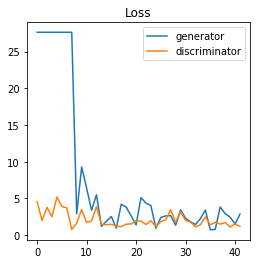


Epoch : 36 

***************************************
batch number= 0
discriminator Loss= 1.0638 | generator Loss= 1.9238 
Loss=: 0.6766 | fake Loss= 0.3872
***************************************
batch number= 5
discriminator Loss= 2.6320 | generator Loss= 0.8174 
Loss=: 2.1961 | fake Loss= 0.4359
***************************************
batch number= 10
discriminator Loss= 1.4476 | generator Loss= 1.0794 
Loss=: 0.9263 | fake Loss= 0.5213
***************************************
batch number= 15
discriminator Loss= 1.2650 | generator Loss= 1.5331 
Loss=: 0.8098 | fake Loss= 0.4552
***************************************
batch number= 20
discriminator Loss= 1.6555 | generator Loss= 1.8570 
Loss=: 1.0250 | fake Loss= 0.6305
***************************************
batch number= 25
discriminator Loss= 1.3344 | generator Loss= 0.9508 
Loss=: 0.8926 | fake Loss= 0.4418
***************************************
batch number= 30
discriminator Loss= 1.5834 | generator Loss= 3.5456 
Loss=: 0.7218 

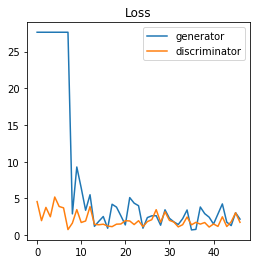


Epoch : 41 

***************************************
batch number= 0
discriminator Loss= 1.5974 | generator Loss= 3.7188 
Loss=: 0.8411 | fake Loss= 0.7563
***************************************
batch number= 5
discriminator Loss= 1.4294 | generator Loss= 2.0916 
Loss=: 1.2804 | fake Loss= 0.1490
***************************************
batch number= 10
discriminator Loss= 1.8281 | generator Loss= 1.5614 
Loss=: 1.3062 | fake Loss= 0.5219
***************************************
batch number= 15
discriminator Loss= 2.4296 | generator Loss= 2.2688 
Loss=: 0.7820 | fake Loss= 1.6475
***************************************
batch number= 20
discriminator Loss= 1.5619 | generator Loss= 1.5993 
Loss=: 1.4483 | fake Loss= 0.1136
***************************************
batch number= 25
discriminator Loss= 2.0673 | generator Loss= 1.6352 
Loss=: 0.9182 | fake Loss= 1.1491
***************************************
batch number= 30
discriminator Loss= 2.4071 | generator Loss= 1.4045 
Loss=: 1.9945 

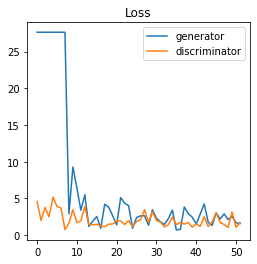


Epoch : 46 

***************************************
batch number= 0
discriminator Loss= 1.7930 | generator Loss= 1.5485 
Loss=: 1.2223 | fake Loss= 0.5707
***************************************
batch number= 5
discriminator Loss= 2.0547 | generator Loss= 1.4283 
Loss=: 1.5523 | fake Loss= 0.5024
***************************************
batch number= 10
discriminator Loss= 1.7645 | generator Loss= 1.6410 
Loss=: 1.0621 | fake Loss= 0.7024
***************************************
batch number= 15
discriminator Loss= 1.6274 | generator Loss= 1.3101 
Loss=: 1.1831 | fake Loss= 0.4443
***************************************
batch number= 20
discriminator Loss= 1.2157 | generator Loss= 0.6439 
Loss=: 0.7314 | fake Loss= 0.4843
***************************************
batch number= 25
discriminator Loss= 1.8808 | generator Loss= 2.3670 
Loss=: 1.3441 | fake Loss= 0.5367
***************************************
batch number= 30
discriminator Loss= 1.7405 | generator Loss= 1.4256 
Loss=: 1.4000 

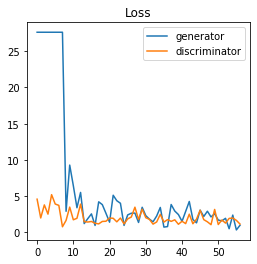


Epoch : 51 

***************************************
batch number= 0
discriminator Loss= 1.2118 | generator Loss= 1.5667 
Loss=: 0.6918 | fake Loss= 0.5200
***************************************
batch number= 5
discriminator Loss= 1.3196 | generator Loss= 0.8812 
Loss=: 0.8225 | fake Loss= 0.4972
***************************************
batch number= 10
discriminator Loss= 1.3684 | generator Loss= 2.3826 
Loss=: 1.1801 | fake Loss= 0.1883
***************************************
batch number= 15
discriminator Loss= 1.8091 | generator Loss= 1.5791 
Loss=: 1.6540 | fake Loss= 0.1551
***************************************
batch number= 20
discriminator Loss= 1.5317 | generator Loss= 2.2641 
Loss=: 0.7457 | fake Loss= 0.7860
***************************************
batch number= 25
discriminator Loss= 1.5040 | generator Loss= 2.2302 
Loss=: 0.6333 | fake Loss= 0.8707
***************************************
batch number= 30
discriminator Loss= 1.4878 | generator Loss= 1.7399 
Loss=: 0.7454 

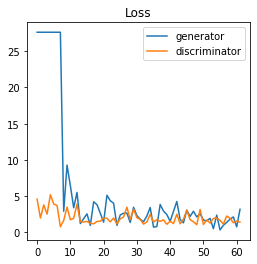


Epoch : 56 

***************************************
batch number= 0
discriminator Loss= 1.7896 | generator Loss= 1.3428 
Loss=: 0.9840 | fake Loss= 0.8056
***************************************
batch number= 5
discriminator Loss= 1.6692 | generator Loss= 2.2014 
Loss=: 0.9722 | fake Loss= 0.6971
***************************************
batch number= 10
discriminator Loss= 1.8812 | generator Loss= 2.0784 
Loss=: 1.4454 | fake Loss= 0.4358
***************************************
batch number= 15
discriminator Loss= 1.4271 | generator Loss= 2.1575 
Loss=: 1.1105 | fake Loss= 0.3166
***************************************
batch number= 20
discriminator Loss= 1.4667 | generator Loss= 1.9106 
Loss=: 1.2016 | fake Loss= 0.2651
***************************************
batch number= 25
discriminator Loss= 1.6849 | generator Loss= 3.3911 
Loss=: 0.7713 | fake Loss= 0.9136
***************************************
batch number= 30
discriminator Loss= 2.0242 | generator Loss= 2.6749 
Loss=: 1.5907 

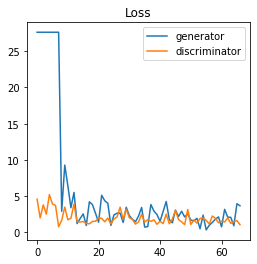


Epoch : 61 

***************************************
batch number= 0
discriminator Loss= 1.5062 | generator Loss= 1.6748 
Loss=: 1.0690 | fake Loss= 0.4372
***************************************
batch number= 5
discriminator Loss= 1.4977 | generator Loss= 2.5316 
Loss=: 0.6790 | fake Loss= 0.8187
***************************************
batch number= 10
discriminator Loss= 1.6799 | generator Loss= 2.6274 
Loss=: 0.8976 | fake Loss= 0.7823
***************************************
batch number= 15
discriminator Loss= 1.6351 | generator Loss= 1.7137 
Loss=: 1.1897 | fake Loss= 0.4455
***************************************
batch number= 20
discriminator Loss= 1.4012 | generator Loss= 1.2254 
Loss=: 0.8234 | fake Loss= 0.5778
***************************************
batch number= 25
discriminator Loss= 1.2591 | generator Loss= 2.3803 
Loss=: 0.9047 | fake Loss= 0.3544
***************************************
batch number= 30
discriminator Loss= 1.6657 | generator Loss= 1.6577 
Loss=: 0.9403 

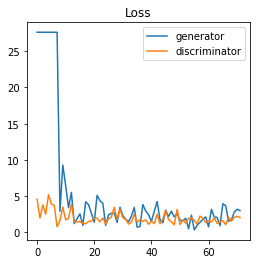


Epoch : 66 

***************************************
batch number= 0
discriminator Loss= 1.7278 | generator Loss= 2.5759 
Loss=: 1.2730 | fake Loss= 0.4548
***************************************
batch number= 5
discriminator Loss= 1.7003 | generator Loss= 2.4026 
Loss=: 0.8432 | fake Loss= 0.8571
***************************************
batch number= 10
discriminator Loss= 2.4031 | generator Loss= 1.0724 
Loss=: 2.1099 | fake Loss= 0.2932
***************************************
batch number= 15
discriminator Loss= 2.6128 | generator Loss= 3.6953 
Loss=: 0.8210 | fake Loss= 1.7918
***************************************
batch number= 20
discriminator Loss= 1.1757 | generator Loss= 0.9759 
Loss=: 0.9514 | fake Loss= 0.2243
***************************************
batch number= 25
discriminator Loss= 1.2891 | generator Loss= 2.3773 
Loss=: 0.7033 | fake Loss= 0.5858
***************************************
batch number= 30
discriminator Loss= 1.6509 | generator Loss= 2.1839 
Loss=: 0.5992 

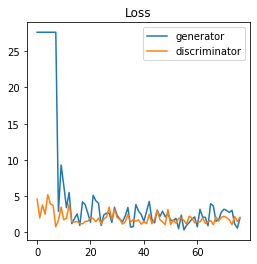


Epoch : 71 

***************************************
batch number= 0
discriminator Loss= 3.0516 | generator Loss= 1.4417 
Loss=: 1.5160 | fake Loss= 1.5357
***************************************
batch number= 5
discriminator Loss= 1.9860 | generator Loss= 1.5153 
Loss=: 1.0080 | fake Loss= 0.9780
***************************************
batch number= 10
discriminator Loss= 1.5727 | generator Loss= 2.2505 
Loss=: 0.8145 | fake Loss= 0.7582
***************************************
batch number= 15
discriminator Loss= 0.9966 | generator Loss= 1.8515 
Loss=: 0.6436 | fake Loss= 0.3530
***************************************
batch number= 20
discriminator Loss= 0.7695 | generator Loss= 2.0922 
Loss=: 0.5255 | fake Loss= 0.2439
***************************************
batch number= 25
discriminator Loss= 1.5573 | generator Loss= 2.8285 
Loss=: 0.6336 | fake Loss= 0.9237
***************************************
batch number= 30
discriminator Loss= 1.6635 | generator Loss= 2.5209 
Loss=: 1.5319 

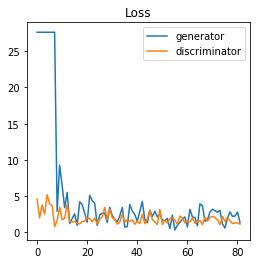


Epoch : 76 

***************************************
batch number= 0
discriminator Loss= 1.5997 | generator Loss= 2.6955 
Loss=: 0.5239 | fake Loss= 1.0759
***************************************
batch number= 5
discriminator Loss= 1.5431 | generator Loss= 1.2633 
Loss=: 0.7850 | fake Loss= 0.7581
***************************************
batch number= 10
discriminator Loss= 1.1080 | generator Loss= 2.2177 
Loss=: 0.8351 | fake Loss= 0.2729
***************************************
batch number= 15
discriminator Loss= 1.2036 | generator Loss= 2.2086 
Loss=: 0.8434 | fake Loss= 0.3602
***************************************
batch number= 20
discriminator Loss= 2.0144 | generator Loss= 3.4241 
Loss=: 0.6630 | fake Loss= 1.3514
***************************************
batch number= 25
discriminator Loss= 1.1861 | generator Loss= 1.4633 
Loss=: 0.8816 | fake Loss= 0.3044
***************************************
batch number= 30
discriminator Loss= 1.5609 | generator Loss= 1.6771 
Loss=: 0.9737 

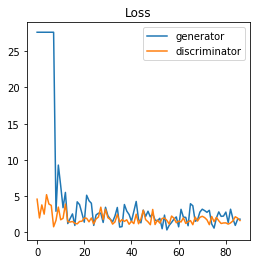


Epoch : 81 

***************************************
batch number= 0
discriminator Loss= 1.4809 | generator Loss= 3.2652 
Loss=: 0.6942 | fake Loss= 0.7867
***************************************
batch number= 5
discriminator Loss= 1.4327 | generator Loss= 3.3301 
Loss=: 0.7902 | fake Loss= 0.6425
***************************************
batch number= 10
discriminator Loss= 1.7438 | generator Loss= 3.4054 
Loss=: 0.6560 | fake Loss= 1.0878
***************************************
batch number= 15
discriminator Loss= 1.7395 | generator Loss= 1.7932 
Loss=: 1.1567 | fake Loss= 0.5829
***************************************
batch number= 20
discriminator Loss= 1.4473 | generator Loss= 1.3383 
Loss=: 0.9609 | fake Loss= 0.4864
***************************************
batch number= 25
discriminator Loss= 1.4309 | generator Loss= 0.4778 
Loss=: 0.9193 | fake Loss= 0.5117
***************************************
batch number= 30
discriminator Loss= 1.1760 | generator Loss= 1.8489 
Loss=: 0.6294 

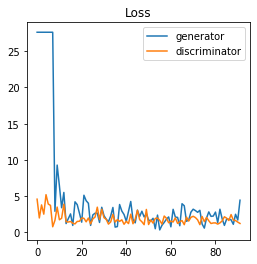


Epoch : 86 

***************************************
batch number= 0
discriminator Loss= 1.4850 | generator Loss= 2.8097 
Loss=: 0.9649 | fake Loss= 0.5201
***************************************
batch number= 5
discriminator Loss= 2.0975 | generator Loss= 3.7490 
Loss=: 0.5635 | fake Loss= 1.5341
***************************************
batch number= 10
discriminator Loss= 1.1650 | generator Loss= 1.6448 
Loss=: 0.9384 | fake Loss= 0.2266
***************************************
batch number= 15
discriminator Loss= 1.3251 | generator Loss= 0.8336 
Loss=: 0.8128 | fake Loss= 0.5123
***************************************
batch number= 20
discriminator Loss= 1.0829 | generator Loss= 1.9160 
Loss=: 0.6028 | fake Loss= 0.4801
***************************************
batch number= 25
discriminator Loss= 1.2894 | generator Loss= 3.8213 
Loss=: 0.5558 | fake Loss= 0.7335
***************************************
batch number= 30
discriminator Loss= 1.4886 | generator Loss= 2.8938 
Loss=: 0.5400 

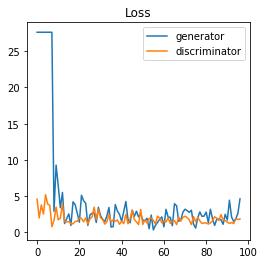


Epoch : 91 

***************************************
batch number= 0
discriminator Loss= 2.1463 | generator Loss= 2.7716 
Loss=: 1.7514 | fake Loss= 0.3949
***************************************
batch number= 5
discriminator Loss= 1.9617 | generator Loss= 1.2972 
Loss=: 1.5399 | fake Loss= 0.4217
***************************************
batch number= 10
discriminator Loss= 1.5422 | generator Loss= 1.9018 
Loss=: 1.2646 | fake Loss= 0.2776
***************************************
batch number= 15
discriminator Loss= 0.9551 | generator Loss= 2.0108 
Loss=: 0.5864 | fake Loss= 0.3687
***************************************
batch number= 20
discriminator Loss= 1.0004 | generator Loss= 1.4482 
Loss=: 0.6768 | fake Loss= 0.3236
***************************************
batch number= 25
discriminator Loss= 1.1776 | generator Loss= 3.2284 
Loss=: 0.6153 | fake Loss= 0.5623
***************************************
batch number= 30
discriminator Loss= 1.1339 | generator Loss= 1.7525 
Loss=: 0.5848 

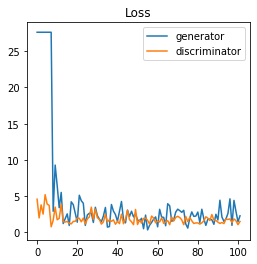


Epoch : 96 

***************************************
batch number= 0
discriminator Loss= 1.9912 | generator Loss= 2.3871 
Loss=: 1.2576 | fake Loss= 0.7336
***************************************
batch number= 5
discriminator Loss= 0.9156 | generator Loss= 3.2174 
Loss=: 0.5975 | fake Loss= 0.3181
***************************************
batch number= 10
discriminator Loss= 1.6195 | generator Loss= 3.4080 
Loss=: 0.6673 | fake Loss= 0.9522
***************************************
batch number= 15
discriminator Loss= 1.8928 | generator Loss= 1.5849 
Loss=: 0.8677 | fake Loss= 1.0251
***************************************
batch number= 20
discriminator Loss= 1.0169 | generator Loss= 1.5758 
Loss=: 0.7042 | fake Loss= 0.3126
***************************************
batch number= 25
discriminator Loss= 1.0940 | generator Loss= 2.4284 
Loss=: 0.7489 | fake Loss= 0.3451
***************************************
batch number= 30
discriminator Loss= 1.1325 | generator Loss= 1.9052 
Loss=: 0.6665 

In [25]:
#training process
epochs = 100 #1000 will be perfection
lossG=[]
lossD=[]
best_loss = np.inf
tolarance = 150

for e in range(0,epochs):
    print("Epoch :",e,'\n')
    for num, (pic, _) in enumerate(TrainLD):
        images = pic.to(device, dtype=torch.float)
        fake = (((torch.rand(len(pic))+1)/2)+0.2).to(device, dtype=torch.float)  
        pure = ((torch.rand(len(pic)))/3).to(device, dtype=torch.float)
        rnd_indexes = set(np.random.randint(len(pic), size=int(0.05*len(pic))))
        for i in rnd_indexes:
            pure[i] = ((pure[i]+1)/2)+0.30
            fake[i] = fake[i] / 2 - 0.7
        
        discriminator.zero_grad()
        outputs_re = discriminator(pic)
        pureLoss = criterion(outputs_re, pure)

        z =  torch.randn((len(pic), latent_dim).to(device))
        picF = generator(z)
        outputs_fe = discriminator(picF.detach())
        fakeLoss = criterion(outputs_fe, fake)

        loss_d = pureLoss + fakeLoss            
        loss_d.backward()                          
        optimizer_d.step()                      
        z = torch.randn((len(images), 100).to(device))
        images_fake = generator(z)
        outputs_fe_gen = discriminator(images_fake)

        generator.zero_grad()
        
        pure = (torch.zeros(len(images))).to(device, dtype=torch.float)
        loss_g = criterion(outputs_fe_gen, pure)
        loss_g.backward()
        optimizer_g.step()
     
        if num % (5) == 0:
            print("***************************************")
            print('batch number= {}' .format(num))
            print('discriminator Loss= {:.4f} | generator Loss= {:.4f} '.format ( loss_d.item(), loss_g.item()))
            print('Loss=: {:.4f} | fake Loss= {:.4f}'.format(loss_real.item(),loss_fake.item()))
    
    print('\nD_loss: {}; G_loss: {}'.format(loss_d.item(), loss_g.item()))

    test_name = R + str(ep) + '.jpg'
    
    test = generator(torch.randn(len(pic), latent_dim).to(device))
    save_image((test+ 1) / 2.0, test_name)
    
    lossD.append(loss_d.item())
    lossG.append(loss_g.item())
    print('min:', min(gen_loss))
    
    if e % 10 == 0:
        print('Minimum Loss:', min(gen_loss))
        plt.figure(figsize=(5,5))
        plt.plot(gen_loss)
        plt.plot(dis_loss)
        plt.legend(['generator','discriminator'])
        plt.show()